In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import pickle
import numpy as np
from jaxoplanet.experimental.starry.multiprecision import mp, utils, solution
from jaxoplanet.core.limb_dark import solution_vector, greens_basis_transform, kappas

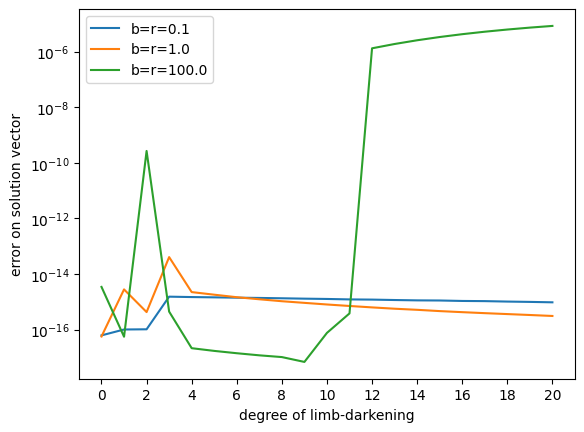

In [33]:
import matplotlib.pyplot as plt

for a in [0.1, 1.0, 100.0]:
    b = r = a
    n = 20
    s1 = np.array(solution_vector(n, 500)(b, r))
    s2 = solution.solution_limb_dark(n, b, r)
    d = utils.diff_mp(s1, s2)
    plt.plot(np.abs(d), label=f"b=r={a}")

plt.yscale("log")
plt.legend()
plt.ylabel("error on solution vector")
plt.xlabel("degree of limb-darkening")
_ = plt.xticks(range(0, 21, 2))

In [19]:
s2

matrix(
[['3.14159265358979323846264338328'],
 ['2.09439510239319549230842892219'],
 ['0.0'],
 ['0.0'],
 ['0.0'],
 ['0.0'],
 ['0.0'],
 ['0.0'],
 ['0.0'],
 ['0.0'],
 ['0.0'],
 ['0.0'],
 ['0.0'],
 ['0.0'],
 ['0.0'],
 ['0.0'],
 ['0.0'],
 ['0.0'],
 ['0.0'],
 ['0.0'],
 ['0.0']])

In [3]:
from scipy.special import binom, roots_legendre
import jax.numpy as jnp

area, k0, k1 = kappas(b, r)
roots, weights = roots_legendre(30)
r2 = r**2
b2 = b**2
phi = k0 - jnp.pi / 2
_b = 2 * jnp.pi + phi
a = jnp.pi - phi
t = (_b - a) / 2 * roots + (a + _b) / 2
s = jnp.sin(t)
f = (1 - r2 - b2 - 2 * _b * r * s) ** (n / 2) * (r + _b * s) * r
(_b - a) / 2 * f.dot(weights)

Array(1.20228448e+45, dtype=float64)

In [7]:
(1 - r2 - b2 - 2 * _b * r * s)

Array([-19054.56912653, -19054.56788958, -19054.56571914, -19054.56270649,
       -19054.55897896, -19054.55469418, -19054.55003333, -19054.5451935 ,
       -19054.54037937, -19054.53579452, -19054.53163284, -19054.52807031,
       -19054.52525761, -19054.52331367, -19054.5223207 , -19054.5223207 ,
       -19054.52331367, -19054.52525761, -19054.52807031, -19054.53163284,
       -19054.53579452, -19054.54037937, -19054.5451935 , -19054.55003333,
       -19054.55469418, -19054.55897896, -19054.56270649, -19054.56571914,
       -19054.56788958, -19054.56912653], dtype=float64)

In [ ]:
a

In [ ]:
roots

In [ ]:
k2 = (1 - r**2 - _b**2 + 2 * _b * r) / 4 * _b * r

In [ ]:
f_new = pickle.load(open("new_results/num_fs_0.01.npz", "rb"))["f"]
f_old = pickle.load(open("old_results/num_fs_0.01.npz", "rb"))["f"]

In [ ]:
import jax.numpy as jnp

g = greens_basis_transform(jnp.ones(n))
g /= jnp.pi * (g[0] + g[1] / 1.5)
g

In [ ]:
import matplotlib.pyplot as plt

d = utils.diff_mp(f_new, f_old)

In [ ]:
from jaxoplanet.experimental.starry.ylm import Ylm


def plot_diff(a, b):
    d = utils.diff_mp(a, b)
    l_max = 20
    l_arr = [0, 1, 2, 3, 5, 8, 10, 13, 15, 18, 20]
    indices = {
        l: np.array([Ylm.index(l, m) for m in range(-l, l + 1)])
        for l in range(l_max + 1)
    }
    cmap = plt.get_cmap("magma")

    for l in l_arr:
        n = indices[l]
        plt.plot(d.T[n].max(0), color=cmap(l / (l_max)), zorder=-1, label=f"l={l}")

    plt.yscale("log")
    plt.legend()

In [ ]:
new = pickle.load(open("main_version_results/num_fs_0.01.npz", "rb"))["f"]
old = pickle.load(open("core_paper_version_results/num_fs_0.01.npz", "rb"))["f"]

In [ ]:
new = np.load("main_version_results/jax_fs_r=0.01_order=500.npz")["s"]
old = np.load("core_paper_version_results/jax_fs_r=0.01_order=500.npz")["s"]

In [ ]:
utils.diff_mp(new, old).max()

In [ ]:
plot_diff(old, new)

In [ ]:
pickle.load(open("data/num_fs_matrices.npz", "rb"))[]

In [ ]:
# LIMBDARK

In [ ]:
from collections.abc import Callable
from functools import partial

import jax
import jax.numpy as jnp
import numpy as np
from scipy.special import binom, roots_legendre

from jaxoplanet.types import Array
from jaxoplanet.utils import zero_safe_sqrt


from jaxoplanet.core.limb_dark import *


def p_integral(
    order: int,
    l_max: int,
    b: Array,
    r: Array,
    b2: Array,
    r2: Array,
    kappa0: Array,
) -> Array:
    # This is a hack for when r -> 0 or b -> 0, so k2 -> inf
    factor = 4 * b * r
    k2_cond = jnp.less(factor, 10 * jnp.finfo(factor.dtype).eps)
    factor: Array = jnp.where(k2_cond, jnp.ones_like(factor), factor)
    k2 = jnp.maximum(jnp.zeros_like(factor), (1 - r2 - b2 + 2 * b * r) / factor)

    roots, weights = roots_legendre(order)
    rng = 0.5 * kappa0
    phi = rng * roots
    c = jnp.cos(phi + 0.5 * kappa0)
    s = jnp.sin(phi)
    s2 = jnp.square(s)

    arg = []
    if l_max >= 1:
        omz2 = jnp.maximum(0, r2 + b2 - 2 * b * r * c)
        print(omz2)
        z2 = 1 - omz2
        m = jnp.less(z2, 10 * jnp.finfo(omz2.dtype).eps)
        z2 = jnp.where(m, jnp.ones_like(z2), z2)
        z3 = z2 * zero_safe_sqrt(z2)
        cond = jnp.less(omz2, 10 * jnp.finfo(omz2.dtype).eps)
        omz2 = jnp.where(cond, jnp.ones_like(z2), omz2)
        result = 2 * r * (r - b * c) * (1 - z3) / (3 * omz2)
        arg.append(jnp.where(cond, jnp.zeros_like(result[None, :]), result[None, :]))
    if l_max >= 3:
        f0 = jnp.maximum(
            jnp.zeros_like(r2), jnp.where(k2_cond, 1 - r2, factor * (k2 - s2))
        )
        n = jnp.arange(3, l_max + 1)
        f = f0[None, :] ** (0.5 * n[:, None])
        f *= 2 * r * (r - b + 2 * b * s2[None, :])
        arg.append(f)

    return rng * jnp.sum(jnp.concatenate(arg, axis=0) * weights[None, :], axis=1)

In [ ]:
from jaxoplanet.experimental.starry.multiprecision import solution
from jaxoplanet.experimental.starry.multiprecision import mp


def kappas(b, r):
    b2 = b**2
    factor = (r - 1) * (r + 1)
    area = solution.kite_area(r, b, 1.0)
    return area, mp.atan2(area, b2 + factor), mp.atan2(area, b2 - factor)


degree = 5
_b = 1.0
r = 1.0


def solution_limb_dark(degree, b, r):
    r2 = r**2
    b2 = b**2
    s = []

    area, k0, k1 = kappas(b, r)
    s0 = mp.pi - k1 - r2 * k0 + area * 0.5
    s.append(s0)

    if degree >= 1:

        def func(x):
            c = mp.cos(2 * x)
            omz2 = r2 + b2 - 2 * b * r * c
            if omz2 <= 0:
                return 0.0
            z2 = 1 - omz2
            z3 = mp.sqrt(z2) * z2
            return 2 * r * (r - b * c) * (1 - z3) / (3 * omz2)

        s1 = -mp.quad(func, [-k0 / 2, k0 / 2]) - 2 * (k1 - mp.pi) / 3

        s.append(s1.real)

    if degree >= 2:
        k2 = (1 - r2 - b2 + 2 * b * r) / (4 * b * r)

        if k2 <= 1:
            eta = (1 / (2 * mp.pi)) * (
                k1 + r2 * (r2 + 2 * b2) * k0 - 0.25 * (1 + 5 * r2 + b2) * area
            )
        elif k2 > 1:
            eta = 0.5 * r2 * (r2 + 2 * b2)

        s2 = 2 * s0 + 4 * mp.pi * eta - 2 * mp.pi
        s.append(s2)

    if degree >= 3:

        for n in range(3, degree + 1):

            def func(x):
                s2 = mp.sin(x) ** 2
                return (k2 - s2) ** (0.5 * n) * (r - b + 2 * s2)

            sn = 2 * r * (4 * b * r) ** (0.5 * n) * mp.quad(func, [-k0 / 2, k0 / 2])
            sn = sn.real

            s.append(-sn)

    return s

In [ ]:
s

In [ ]:
from jaxoplanet.core.limb_dark import solution_vector, kappas

solution_vector(degree)(_b, r)

In [ ]:
kappas(_b, r)

In [1]:
import numpy as np
import starry

starry.config.lazy = False


r = 0.1
bs = [0.1]
l_max = 5
ys = np.eye(6**2)


map = starry.Map(ydeg=l_max)


S = []

for b in bs:
    try:
        val = map.ops.sT([b], [r])[0]
    except:
        val = np.nan * np.ones(map.Ny)

    S.append(val)

S = np.array(S)


flux = []
from tqdm import tqdm

for y in tqdm(ys):

    map[:, :] = y
    f = map.flux(xo=0.0, yo=bs, zo=10.0, ro=r)
    flux.append(f)

flux = np.array(flux).T

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/lgarcia/mambaforge/envs/test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Pre-computing some matrices... Done.
Compiling `sT`... Done.
  0%|          | 0/36 [00:00<?, ?it/s]



You can find the C code in this temporary file: /var/folders/wn/j_ytm31108z7jt5f1x0d7j1c0000gq/T/theano_compilation_error_a73sqn7r


Exception: ('The following error happened while compiling the node', Elemwise{Cast{int16}}(<TensorType(int64, vector)>), '\n', "Compilation failed (return status=1): /Users/lgarcia/.theano/compiledir_macOS-14.7-arm64-arm-64bit-arm-3.10.15-64/tmpt4e1fah1/mod.cpp:2:10: fatal error: 'iostream' file not found.     2 | #include <iostream>.       |          ^~~~~~~~~~. 1 error generated.. ", 'FunctionGraph(Elemwise{Cast{int16}}(<TensorType(int64, vector)>))')

In [10]:
u @ U(2)

array([-2.,  0.,  3.,  0.,  1.,  0.,  0.,  0.,  1.])